In [110]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

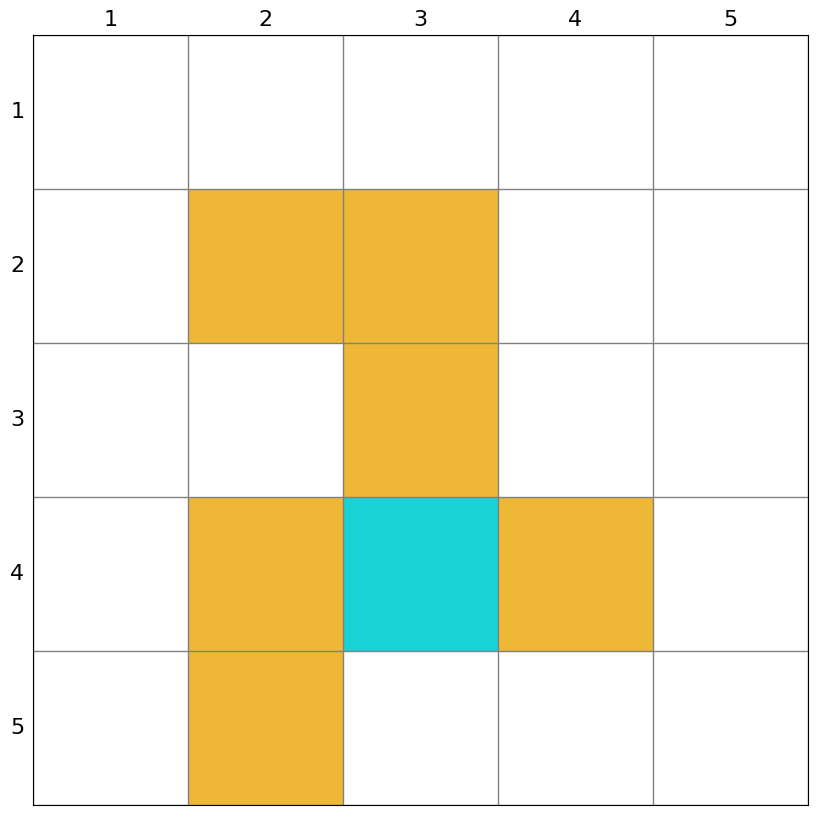

In [111]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [112]:
def MC_greedy(env, epsilon=0, gamma=0.8, length=1000, epochs=5): 
    state_space_size = env.size ** 2  # 状态空间的大小
    action_space_size = env.action_space_size  # 动作空间的大小

    # 初始化Q值表
    qvalue = np.zeros((state_space_size, action_space_size))
    
    # 初始化all_returns字典，用于存储每个状态-动作对的所有回报
    all_returns = { (s, a): [] for s in range(state_space_size) for a in range(action_space_size) }

    # 初始化策略为均匀随机策略
    policy = np.ones((state_space_size, action_space_size)) / action_space_size

    # 初始化 state_value 表
    state_value = np.zeros(state_space_size)
    # 目标：寻找最优策略
    for epoch in range(epochs):
        for state in range(state_space_size):
            for action in range(action_space_size):
                # 生成一个episode，随机选择一个起始状态-动作对 (s_0, a_0)
                env.agent_location = env.state2pos(state)
                episode = []
                next_action = action
                next_state = state
                episode_length = length

                # 生成 episode (s_0, a_0, r_1, ..., s_T−1, a_T−1, r_T)
                while episode_length > 0:
                    episode_length -= 1
                    state = next_state
                    action = next_action
                    _, reward, done, _, _ = env.step(action)  # 执行动作并获得奖励
                    next_state = env.pos2state(env.agent_location)
                    next_action = np.random.choice(np.arange(len(policy[next_state])), p=policy[next_state])

                    # 将 (state, action, reward, next_state, next_action) 加入 episode
                    episode.append({
                        "state": state, 
                        "action": action, 
                        "reward": reward, 
                        "next_state": next_state, 
                        "next_action": next_action
                    })

                    if done:
                        break
                
                # 策略评估与改进
                g = 0  # 初始化回报g
                for step in range(len(episode) - 1, -1, -1):
                    g = episode[step]['reward'] + gamma * g
                    s = episode[step]['state']
                    a = episode[step]['action']

                    # 将回报加入到相应的状态-动作对
                    all_returns[(s, a)].append(g)
                    # 更新Q值，采用回报的平均值
                    qvalue[s][a] = np.mean(all_returns[(s, a)])

        # 根据Q值最大化更新策略π，采用ε-贪婪策略
        for s in range(state_space_size):
            best_action = np.argmax(qvalue[s])  # 找到最大的Q值对应的动作
            for a in range(action_space_size):
                if a == best_action:
                    policy[s][a] = 1 - epsilon + epsilon / action_space_size  # 贪婪选择
                else:
                    policy[s][a] = epsilon / action_space_size  # 随机选择
        
        # 计算每个状态的价值 (state value)
        for s in range(state_space_size):
            state_value[s] = np.max(qvalue[s])  # V(s) = max(Q(s, a))

    return policy,state_value


In [113]:
#这样修改后的代码会从一个状态出发，逐渐通过 env.step() 探索所有状态，并且每个状态-动作对的 Q 值会根据生成的 episode 来进行更新。
def MC_greedy_oneplace(env, epsilon=0.5, gamma=0.8, length=100, epochs=5):
    state_space_size = env.size ** 2  # 状态空间的大小
    action_space_size = env.action_space_size  # 动作空间的大小

    # 初始化Q值表
    qvalue = np.zeros((state_space_size, action_space_size))
    
    # 初始化all_returns字典，用于存储每个状态-动作对的所有回报
    all_returns = { (s, a): [] for s in range(state_space_size) for a in range(action_space_size) }

    # 初始化策略为均匀随机策略
    policy = np.ones((state_space_size, action_space_size)) / action_space_size

    # 目标：寻找最优策略
    for epoch in range(epochs):
        # 每次从随机起始状态出发
        start_state = np.random.choice(state_space_size)
        for _ in range(length):  # 执行多个episode直到访问所有状态
            # 生成一个episode，随机选择一个起始状态
            env.agent_location = env.state2pos(start_state)
            episode = []
            next_state = start_state
            episode_length = length

            # 生成 episode (s_0, a_0, r_1, ..., s_T−1, a_T−1, r_T)
            while episode_length > 0:
                episode_length -= 1
                state = next_state
                action = np.random.choice(np.arange(len(policy[state])), p=policy[state])  # 按当前策略选择动作
                _, reward, done, _, _ = env.step(action)  # 执行动作并获得奖励
                next_state = env.pos2state(env.agent_location)

                # 将 (state, action, reward, next_state) 加入 episode
                episode.append({
                    "state": state, 
                    "action": action, 
                    "reward": reward, 
                    "next_state": next_state
                })

                if done:
                    break
            
            # 策略评估与改进
            g = 0  # 初始化回报g
            for step in range(len(episode) - 1, -1, -1):
                g = episode[step]['reward'] + gamma * g
                s = episode[step]['state']
                a = episode[step]['action']

                # 将回报加入到相应的状态-动作对
                all_returns[(s, a)].append(g)
                # 更新Q值，采用回报的平均值
                qvalue[s][a] = np.mean(all_returns[(s, a)])

        # 根据Q值最大化更新策略π，采用ε-贪婪策略
        for s in range(state_space_size):
            best_action = np.argmax(qvalue[s])  # 找到最大的Q值对应的动作
            for a in range(action_space_size):
                if a == best_action:
                    policy[s][a] = 1 - epsilon + epsilon / action_space_size  # 贪婪选择
                else:
                    policy[s][a] = epsilon / action_space_size  # 随机选择

    return policy

In [114]:
def obtain_episode(env, policy, start_state, start_action, length):
        f"""

        :param policy: 由指定策略产生episode
        :param start_state: 起始state
        :param start_action: 起始action
        :param length: episode 长度
        :return: 一个 state,action,reward,next_state,next_action 序列
        """
        env.agent_location = env.state2pos(start_state)
        episode = []
        next_action = start_action
        next_state = start_state
        while length > 0:
            length -= 1
            state = next_state
            action = next_action
            _, reward, done, _, _ = env.step(action)
            next_state = env.pos2state(env.agent_location)
            next_action = np.random.choice(np.arange(len(policy[next_state])),
                                           p=policy[next_state])
            episode.append({"state": state, "action": action, "reward": reward, "next_state": next_state,
                            "next_action": next_action})
        return episode

In [115]:
def mc_epsilon_greedy(env,length=1000, epsilon=1, tolerance=1 ,gamma = 0.9):
    state_space_size = env.size ** 2  # 状态空间的大小
    action_space_size = env.action_space_size  # 动作空间的大小
    
    # 初始化all_returns字典，用于存储每个状态-动作对的所有回报
    all_returns = { (s, a): [] for s in range(state_space_size) for a in range(action_space_size) }

    # 初始化策略为均匀随机策略
    policy = np.ones((state_space_size, action_space_size)) / action_space_size
    norm_list = []
    qvalue = np.random.random(size=(state_space_size, action_space_size))
    returns = [[[0 for row in range(1)] for col in range(5)] for block in range(25)]
    while True:
        if epsilon >= 0.01:
            epsilon -= 0.01
            print(epsilon)
        length = 20 + epsilon * length
        if len(norm_list) >= 3:
            if norm_list[-1] < tolerance and norm_list[-2] < tolerance and norm_list[-3] < tolerance:
                break

        # length = epsilon * length
        # if epsilon >= 0.01:
        #     epsilon -= 0.01
        n_qvalue = qvalue.copy()
        # for state in range(self.state_space_size):
        #     for action in range(self.action_space_size):
        state = random.choice(range(state_space_size))

        action = random.choice(range(action_space_size))

        episode = obtain_episode(env, policy=policy, start_state=state, start_action=action,
                            length=length)
        g = 0
        for step in range(len(episode) - 1, -1, -1):
            reward = episode[step]['reward']
            state = episode[step]['state']
            action = episode[step]['action']
            g = gamma * g + reward
            # every visit
            returns[state][action].append(g)
            qvalue[state, action] = np.array(returns[state][action]).mean()
            qvalue_star = qvalue[state].max()
            action_star = qvalue[state].tolist().index(qvalue_star)
            for a in range(action_space_size):
                if a == action_star:
                    policy[state, a] = 1 - (
                            action_space_size - 1) / action_space_size * epsilon
                else:
                    policy[state, a] = 1 / action_space_size * epsilon
        print(np.linalg.norm(qvalue - n_qvalue, ord=1))
        norm_list.append(np.linalg.norm(qvalue - n_qvalue, ord=1))

    print(len(norm_list))
    return policy

In [116]:
policy = mc_epsilon_greedy(env)
print(policy)

0.99
719.605930967816
0.98
78.86762424706124
0.97
52.71033784387869
0.96
30.367885082699196
0.95
23.944092351807033
0.94
22.36520500146031
0.9299999999999999
18.398590005852263
0.9199999999999999
24.180033909861706
0.9099999999999999
12.887325330029
0.8999999999999999
13.687513139162274
0.8899999999999999
14.232004683467899
0.8799999999999999
9.398218869116734
0.8699999999999999
11.120046656294528
0.8599999999999999
11.32604064887829
0.8499999999999999
7.35563663741493
0.8399999999999999
8.087706806108917
0.8299999999999998
4.8785843546506165
0.8199999999999998
6.849234027872083
0.8099999999999998
4.390670528767076
0.7999999999999998
4.223130166879757
0.7899999999999998
4.376505380940822
0.7799999999999998
3.81549157080595
0.7699999999999998
2.364788081246136
0.7599999999999998
1.7161911672649648
0.7499999999999998
3.459037023068908
0.7399999999999998
1.6829059201805237
0.7299999999999998
2.1335334916465296
0.7199999999999998
2.389610849289962
0.7099999999999997
1.2638957358530805
0.69

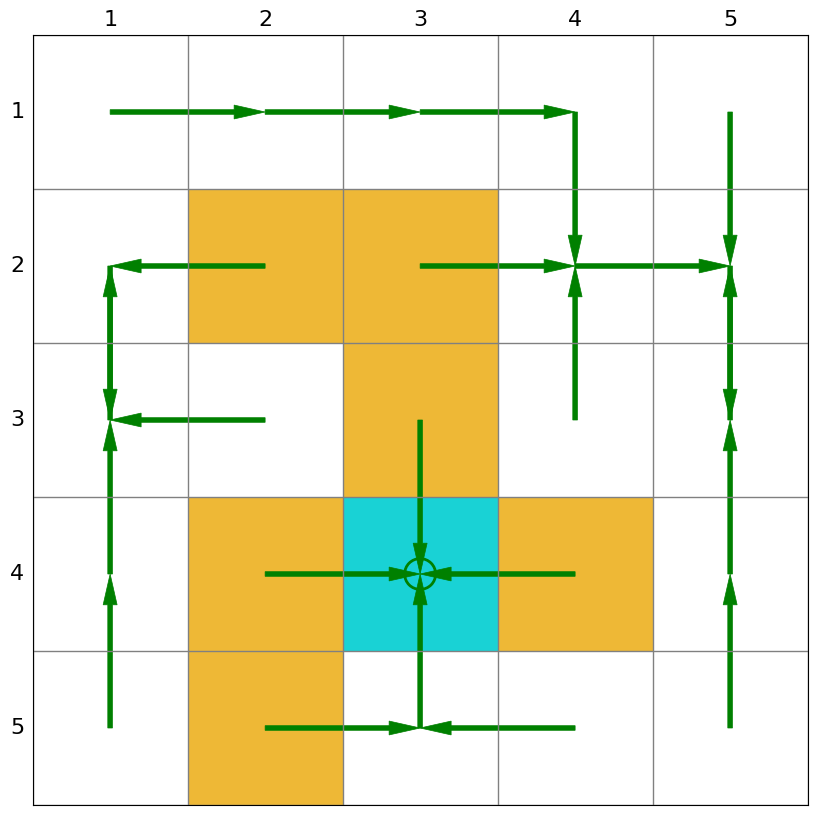

In [117]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()